# **Análisis Exploratorio y Preprocesado de Datos**
---
**Autor:** Juan Felipe Quinto Rios
- **dataset:** `dataset_alpha_betha.csv`

> En este notebook realizamos la limpieza de datos, el análisis inicial y las transformaciones necesarias para generar cuatro conjuntos de características (bloques A, B, C y D) que luego usaremos en nuestros experimentos de modelado. Cada bloque se justifica mediante un pequeño análisis que muestra por qué se hizo cada operación y cómo se obtuvieron  las columnas finales.


# **1. Carga de datos**

En esta sección importamos las librerías necesarias y cargamos el archivo original `dataset_alpha_betha.csv`. Así obtenemos un primer vistazo a la estructura, los tipos de datos y el tamaño de nuestro DataFrame.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Ruta al CSV original
DATA_PATH = 'LAB_ML\Clasificacion_Regresion\raw_data\dataset_alpha_betha.csv'

# Carga del DataFrame
df = pd.read_csv(DATA_PATH)

# Mostrar dimensiones y tipos
print('Shape:', df.shape)
df.info()


Shape: (7043, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   autoID            7043 non-null   object 
 1   SeniorCity        7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   Service1          7043 non-null   object 
 5   Service2          7043 non-null   object 
 6   Security          7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  Contract          7043 non-null   object 
 11  PaperlessBilling  7043 non-null   object 
 12  PaymentMethod     7043 non-null   object 
 13  Charges           7043 non-null   float64
 14  Demand            7043 non-null   object 
 15  Class             7043 non-null   object 
dtypes: float64(1), int64(1),

tamaño (7043 filas) y los 16 campos con sus tipos (casi todos `object` menos Charges y una variable `booleana` inicial)

# **2. Limpieza inicial de la columna Demand**

Aquí identificamos y eliminamos las filas donde `Demand` está vacía (cadena en blanco), y convertimos esa columna a tipo numérico. Esto es necesario porque necesitamos Demand como flotante para el análisis y los modelos.

In [2]:
# Contar filas donde Demand es cadena vacía
print(df[df['Demand'] == ' '].count())

# Filtrar y convertir
df = df[df['Demand'] != ' '].copy()
df['Demand'] = df['Demand'].astype(float)

# Verificación final
print('Dimensiones tras limpieza:', df.shape)


autoID              11
SeniorCity          11
Partner             11
Dependents          11
Service1            11
Service2            11
Security            11
OnlineBackup        11
DeviceProtection    11
TechSupport         11
Contract            11
PaperlessBilling    11
PaymentMethod       11
Charges             11
Demand              11
Class               11
dtype: int64
Dimensiones tras limpieza: (7032, 16)


Asegurarnos de que `Demand` no tenga valores no numéricos y trabajar solo con entradas válidas (7032 filas).

# **3. Análisis de variables categóricas**

Realizamos conteos y porcentajes de cada nivel en las columnas object (excepto `autoID`) para entender la frecuencia de “Yes/No”, “No internet service”, “No phone service” y las categorías de Contract y PaymentMethod.

In [3]:
from IPython.display import display, HTML

cols_to_analyze = [col for col in df.select_dtypes(include='object').columns if col != 'autoID']
summary_tables = {}

for col in cols_to_analyze:
    counts = df[col].value_counts(dropna=False)
    percents = df[col].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({'Count': counts, 'Percentage': percents.round(2)})
    summary_tables[col] = summary

# Concatenar en un solo DataFrame para mostrarlo en bloque scrollable
all_summaries = []
for col_name, summary_df in summary_tables.items():
    temp = summary_df.copy()
    temp['Variable'] = col_name
    temp['Category'] = temp.index
    all_summaries.append(temp.reset_index(drop=True))

combined_summary = pd.concat(all_summaries, ignore_index=True)[['Variable','Category','Count','Percentage']]

styles = """
<style>
.scroll-table {
    height: 400px;
    overflow-y: scroll;
    display: block;
    border: 1px solid #ccc;
}
</style>
"""

html_table = combined_summary.to_html(index=False)
display(HTML(styles + f'<div class="scroll-table">{html_table}</div>'))


Variable,Category,Count,Percentage
Partner,No,3639,51.75
Partner,Yes,3393,48.25
Dependents,No,4933,70.15
Dependents,Yes,2099,29.85
Service1,Yes,6352,90.33
Service1,No,680,9.67
Service2,No,3385,48.14
Service2,Yes,2967,42.19
Service2,No phone service,680,9.67
Security,No,3497,49.73


- Visualizar que columnas como Service2 tienen tres niveles (“Yes”, “No” y “No phone service”) y que varias variables contienen “No internet service”.

- Determinar cómo simplificar estas categorías para no tener niveles redundantes en los modelos

# **4. Transformación de indicadores de servicio**

A partir de la información anterior, creamos una bandera binaria `InternetService` para indicar si el cliente tiene o no servicio de internet, y reemplazamos “No internet service” por “No” en todas las columnas que lo continen. También eliminamos “No phone service” en `Service2`, ya que de todos modos existe el indicador `Service1` que basta para saber si hay servicio de teléfono.

In [4]:
# 4.1. Bandera de internet: 0 si ‘Security’ es “No internet service”, 1 en otro caso
df['InternetService'] = df['Security'].apply(lambda x: 0 if x == 'No internet service' else 1)

# 4.2. Reemplazar “No internet service” por “No” en las columnas de addons
servicios = ["Security", "TechSupport", "OnlineBackup", "DeviceProtection"]
df[servicios] = df[servicios].replace("No internet service", "No")

# 4.3. En Service2, “No phone service” → “No”
df['Service2'] = df['Service2'].replace("No phone service", "No")

# 4.4. Convertir “Yes”/“No” a 1/0
columns_to_convert = [
    'Partner', 'Service1', 'TechSupport', 'PaperlessBilling',
    'Security', 'DeviceProtection', 'Dependents', 'OnlineBackup',
    'Service2'
]
df[columns_to_convert] = df[columns_to_convert].replace({'Yes': 1, 'No': 0})

# 4.5. Crear flag de clase: Alpha → 0, Betha → 1
df["Class_flag"] = df["Class"].map({"Alpha": 0, "Betha": 1})


- Simplificar las columnas binarias de servicios sin crear niveles redundantes.

- Habilitar un único campo `InternetService` en lugar de múltiples “No internet service”.

- Obtener señales binarias limpias (`0/1`) para el modelado y la ingeniería de variables.

# **5. Transformación de variables ordinales y flags de pago**

Creamos tres nuevas columnas:

1. `Contract_months`: sustituye “Month-to-month” → 1, “One year” → 12, “Two year” → 24.

2. `AutoPayment_flag`: indica si el método de pago es automático (`Bank transfer` o `Credit card`).

3. `PaymentMethod_simple`: agrupa los métodos de pago en 3 categorías (“Automatic”, “Electronic check”, “Mailed check”) para luego hacer one-hot encoding.

In [5]:
# 5.1. Contrato a meses
df["Contract_months"] = df["Contract"].map({
    "Month-to-month": 1,
    "One year":      12,
    "Two year":      24
})

# 5.2. Flag de pago automático
df["AutoPayment_flag"] = df["PaymentMethod"].isin([
    "Bank transfer (automatic)", "Credit card (automatic)"
]).astype(int)

# 5.3. Simplificar PaymentMethod para one-hot
df["PaymentMethod_simple"] = df["PaymentMethod"].replace({
    "Bank transfer (automatic)": "Automatic",
    "Credit card (automatic)":   "Automatic",
    "Electronic check":          "Electronic check",
    "Mailed check":              "Mailed check"
})


- Convertir la columna ordinal `Contract` a valores numéricos para que el modelo pueda interpretarla como orden.
- Generar un indicador binario para métodos de pago automático.
- Reducir la cardinalidad de `PaymentMethod` antes de codificarla con one-hot, manteniendo el significado de cada modalidad.

# **6. Análisis univariado de variables numéricas**

En este punto examinamos las características numéricas (`Charges`, `Demand`, `Contract_months`) para identificar sesgos y posibles transformaciones. Calculamos estadísticos, skews, kurtosis, historiales y boxplots.

,count,mean,std,min,25%,50%,75%,max
Charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
Demand,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
Contract_months,7032.0,8.813851,9.541690,1.00,1.0000,1.000,12.0000,24.00


,Skewness,Kurtosis
Charges,-0.222103,-1.256156
Demand,0.961642,-0.231799
Contract_months,0.671474,-1.211585


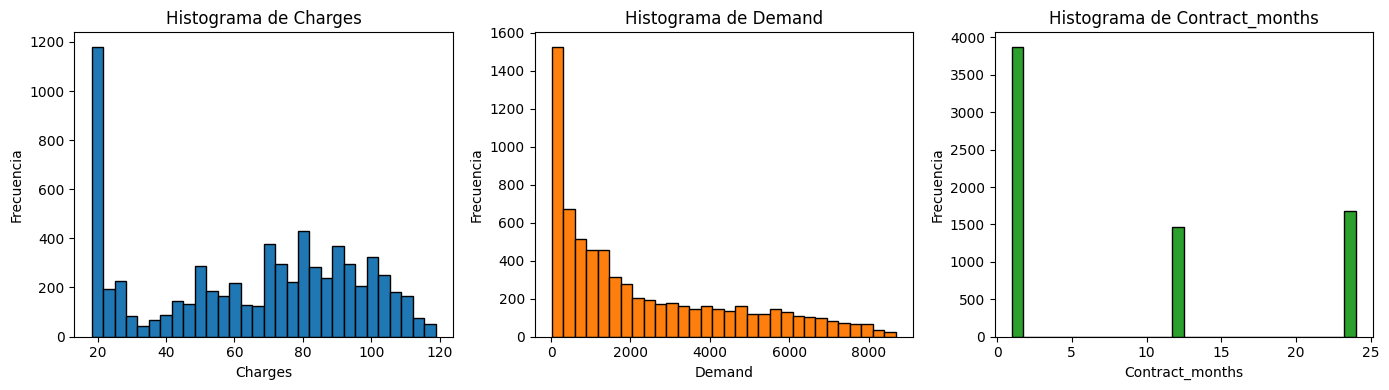

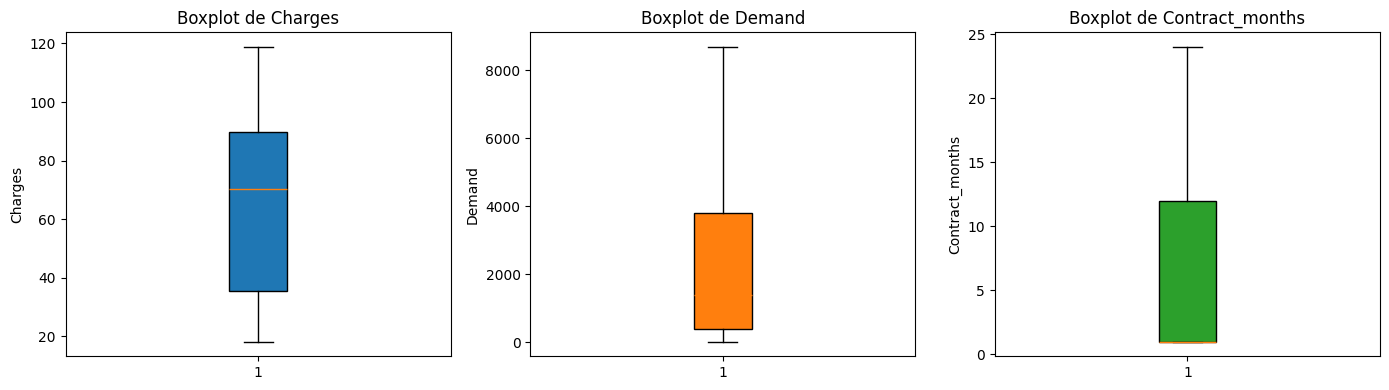

In [6]:
# 6.1. Estadísticos descriptivos
cols_num = ["Charges", "Demand", "Contract_months"]
display(df[cols_num].describe().T)

# 6.2. Skewness y Kurtosis
skew_kurt = df[cols_num].agg(["skew", "kurtosis"]).T
skew_kurt.columns = ["Skewness", "Kurtosis"]
display(skew_kurt)

# 6.3. Histogramas
plt.figure(figsize=(14, 4))
for i, col in enumerate(cols_num):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=30, color=f"C{i}", edgecolor="black")
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# 6.4. Boxplots
plt.figure(figsize=(14, 4))
for i, col in enumerate(cols_num):
    plt.subplot(1, 3, i+1)
    plt.boxplot(df[col], vert=True, patch_artist=True, boxprops=dict(facecolor=f"C{i}"))
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)
plt.tight_layout()
plt.show()


**Observaciones:**

- **Charges:** leve sesgo negativo, concentración central en 35–90.

- **Demand:** cola larga a la derecha, fuertes valores atípicos (hasta ~8 700).

- **Contract_months:** mayoría en “1 mes” (contrato mensual).

Para mitigar la cola de `Demand` y reducir el impacto de outliers, creamos `Demand_log = log1p(Demand)`.

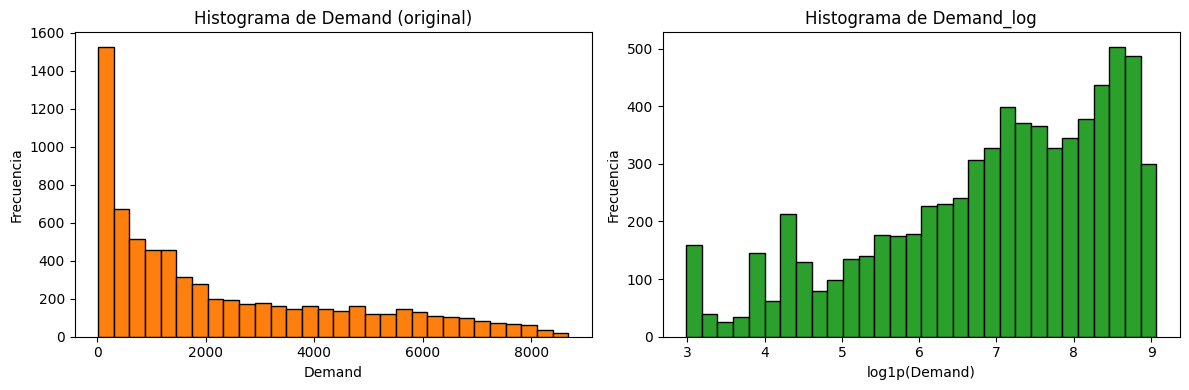

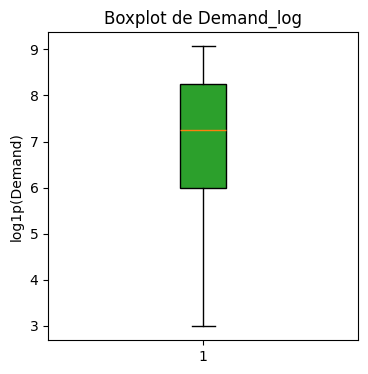

Skewness Demand: 0.962
Skewness Demand_log: -0.743


In [7]:
df["Demand_log"] = np.log1p(df["Demand"])

# Comparar distribuciones antes y después
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df["Demand"], bins=30, color="C1", edgecolor="black")
plt.title("Histograma de Demand (original)")
plt.xlabel("Demand")
plt.ylabel("Frecuencia")

plt.subplot(1, 2, 2)
plt.hist(df["Demand_log"], bins=30, color="C2", edgecolor="black")
plt.title("Histograma de Demand_log")
plt.xlabel("log1p(Demand)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Boxplot de Demand_log
plt.figure(figsize=(4, 4))
plt.boxplot(df["Demand_log"], vert=True, patch_artist=True, boxprops=dict(facecolor="C2"))
plt.title("Boxplot de Demand_log")
plt.ylabel("log1p(Demand)")
plt.show()

print("Skewness Demand:", df["Demand"].skew().round(3))
print("Skewness Demand_log:", df["Demand_log"].skew().round(3))


`Demand_log` disminuye el sesgo (de ~0.96 a ~–0.74), facilitando su uso en modelos lineales. Sin embargo, en algoritmos de árbol podríamos usar Demand original; por eso, mantendremos ambas versiones en nuestros datos.

# **7. Análisis preliminar de clasificación**

Se revisa la relación entre variables clave y la variable objetivo `Class_flag`. Esto nos ayuda a decidir si vale la pena crear nuevas variables o quedarnos con las originales.

In [8]:
import plotly.express as px

# Boxplot de Charges vs Class_flag
fig = px.box(df, y="Charges", x="Class_flag", title="Charges por Clase")
fig.show()

# Proporciones de variables binarias para cada clase
cols_bin = ['SeniorCity', 'Partner', 'Dependents', 'Service1', 'Service2',
            'Security', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'PaperlessBilling', 'InternetService', 'AutoPayment_flag']

for col in cols_bin:
    print(f"\nProporción de {col} según Class_flag:")
    print((df.groupby('Class_flag')[col].value_counts(normalize=True) * 100).round(2))
    print("-" * 40)

# Proporción de Contract_months y PaymentMethod_simple según clase
print("\nProporción de Contract_months según Class_flag:")
print((df.groupby('Class_flag')['Contract_months'].value_counts(normalize=True) * 100).round(2))
print("-" * 40)

print("\nProporción de PaymentMethod_simple según Class_flag:")
print((df.groupby('Class_flag')['PaymentMethod_simple'].value_counts(normalize=True) * 100).round(2))
print("-" * 40)



Proporción de SeniorCity según Class_flag:
Class_flag  SeniorCity
0           0             87.10
            1             12.90
1           0             74.53
            1             25.47
Name: proportion, dtype: float64
----------------------------------------

Proporción de Partner según Class_flag:
Class_flag  Partner
0           1          52.76
            0          47.24
1           0          64.21
            1          35.79
Name: proportion, dtype: float64
----------------------------------------

Proporción de Dependents según Class_flag:
Class_flag  Dependents
0           0             65.66
            1             34.34
1           0             82.56
            1             17.44
Name: proportion, dtype: float64
----------------------------------------

Proporción de Service1 según Class_flag:
Class_flag  Service1
0           1           90.12
            0            9.88
1           1           90.90
            0            9.10
Name: proportion, dtype: flo

- `Charges` tiende a ser mayor en la clase Betha.

- Clientes con contratos mensuales (`Contract_months = 1`) representan casi 89 % de Betha.

- El método de pago “`Electronic check`” es más común en Betha (57 %) que en Alpha.

Estos patrones respaldan la decisión de usar `Contract_months`, `Charges` y un agrupamiento de pagos para separar grupos.

# **8. Ingeniería de nuevas características**

Con el fin de capturar mejor las interacciones y la combinación de servicios, creamos tres variables adicionales que servirán en los bloques B y D:

1. **TotalAddOns**: suma de las cuatro columnas de servicios de internet (Security, OnlineBackup, DeviceProtection, TechSupport).

2. **Charges_per_AddOn**: ratio entre Charges y TotalAddOns + 1 (evita división por cero).

3. **Contract_x_Charges**: producto de Contract_months × Charges, para reflejar interacción entre monto mensual y tarifa.

In [9]:
# 8.1. Total de addons por cliente
df["TotalAddOns"] = (
    df["Security"]
  + df["OnlineBackup"]
  + df["DeviceProtection"]
  + df["TechSupport"]
)

# 8.2. Costo por addon
df["Charges_per_AddOn"] = df["Charges"] / (df["TotalAddOns"] + 1)

# 8.3. Interacción entre contrato y cargo
df["Contract_x_Charges"] = df["Contract_months"] * df["Charges"]


**Justifiación:**

- si un cliente tiene varios addons, quizá su consumo difiera; agruparlos en `TotalAddOns` simplifica el modelo.
- Calcular `Charges_per_AddOn` ayuda a evaluar si el monto cobrado se divide uniformemente entre los servicios o si hay consumo “pesado” en uno solo.
- La interacción `Contract_x_Charges` refleja que un contrato más largo combinado con un cargo elevado podría influir en la demanda o en la etiqueta Betha.

# **9. Definición de bloques de features y guardado de CSVs**

En esta sección agrupamos distintas combinaciones de columnas — desde el bloque más simple (bloque A) hasta el más completo (bloque D) — y guardamos cada uno en un CSV independiente. Esto nos permitirá comparar en la fase de modelado cómo rinden cada conjunto de características.

## **9.1. Bloque A (features “crudos”)**

Incluye todas las columnas binarias originales, `Charges`, `Contract_months` y `PaymentMethod_simple`.
Estas variables cubren los datos mínimos necesarios sin ingeniería adicional.

In [ ]:
cols_A = [
    "SeniorCity", "Partner", "Dependents",
    "Service1", "Service2", "Security",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "PaperlessBilling", "InternetService", "AutoPayment_flag",
    "Charges", "Contract_months", "PaymentMethod_simple",
    "Demand", "Class_flag"
]

df_A = df[cols_A].copy()
df_A.to_csv("LAB_ML\Clasificacion_Regresion\transformed_data\dataset_A_raw.csv", index=False)
print("Guardado: dataset_A_raw.csv")


Guardado: dataset_A_raw.csv


- Este bloque permite ver si las variables originale, binarias e individuales junto con tarifa y duración del contrato son suficientes para predecir nuestros targets.

## **9.2. Bloque B (suma de AddOns)**

Sustituye las cuatro columnas de servicio de internet (`Security`, `OnlineBackup`, `DeviceProtection`, `TechSupport`) por la variable `TotalAddOns`, manteniendo el resto de columnas binarias del bloque A. Así evitamos colinealidad entre esos flags.

In [ ]:
cols_B = [
    "SeniorCity", "Partner", "Dependents",
    "Service1", "Service2", "PaperlessBilling",
    "InternetService", "AutoPayment_flag",
    "Charges", "Contract_months",
    "TotalAddOns", "PaymentMethod_simple",
    "Demand", "Class_flag"
]

df_B = df[cols_B].copy()
df_B.to_csv("LAB_ML\Clasificacion_Regresion\transformed_data\dataset_B_addon_sum.csv", index=False)
print("Guardado: dataset_B_addon_sum.csv")


Guardado: dataset_B_addon_sum.csv


- Consolidar los servicios de internet en un solo conteo (`TotalAddOns`) puede reducir ruido y facilitar la interpretación de cuántos addons tiene en total cada cliente, en lugar de analizarlos por separado.

## **9.3. Bloque C (interacción contrato × cargo)**

Preservamos todas las variables binarias del bloque A y agregamos la interacción `Contract_x_Charges`. No incluimos `TotalAddOns` para ver el efecto aislado de esta nueva interacción.

In [ ]:
cols_C = [
    "SeniorCity", "Partner", "Dependents",
    "Service1", "Service2", "Security",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "PaperlessBilling", "InternetService", "AutoPayment_flag",
    "Charges", "Contract_months", "Contract_x_Charges",
    "PaymentMethod_simple", "Demand", "Class_flag"
]

df_C = df[cols_C].copy()
df_C.to_csv("LAB_ML\Clasificacion_Regresion\transformed_data\dataset_C_contractx.csv", index=False)
print("Guardado: dataset_C_contractx.csv")


Guardado: dataset_C_contractx.csv


- La variable `Contract_x_Charges` puede capturar patrones de comportamiento: clientes con contratos largos y cargos altos tal vez se comporten distinto a quienes tienen contratos cortos con cargos moderados.

## **9.4. Bloque D (ingeniería completa)**

Incluye todas las columnas del bloque A, más `TotalAddOns`, `Charges_per_AddOn` y `Contract_x_Charges`. Es nuestro bloque más rico en ingeniería de features.

In [ ]:
cols_D = [
    "SeniorCity", "Partner", "Dependents",
    "Service1", "Service2", "Security",
    "OnlineBackup", "DeviceProtection", "TechSupport",
    "PaperlessBilling", "InternetService", "AutoPayment_flag",
    "Charges", "Contract_months", "TotalAddOns",
    "Charges_per_AddOn", "Contract_x_Charges",
    "PaymentMethod_simple", "Demand", "Class_flag"
]

df_D = df[cols_D].copy()
df_D.to_csv("LAB_ML\Clasificacion_Regresion\transformed_data\dataset_D_fulleng.csv", index=False)
print("Guardado: dataset_D_fulleng.csv")


Guardado: dataset_D_fulleng.csv


- Combinamos todas las transformaciones para analizar el efecto conjunto de addons totales, costo por addon e interacción contrato×cargo, junto con las variables originales.

#  **10. Estado final del DataFrame y dimensiones de cada bloque**

Para confirmar que cada CSV quedó con el tamaño correcto y sin valores nulos, verificamos información y dimensiones.

In [14]:
for name, df_block in zip(
    ["A_raw", "B_addon_sum", "C_contractx", "D_fulleng"],
    [df_A, df_B, df_C, df_D]
):
    print(f"{name}: shape = {df_block.shape}")
    display(df_block.head(2))


A_raw: shape = (7032, 17)


,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,InternetService,AutoPayment_flag,Charges,Contract_months,PaymentMethod_simple,Demand,Class_flag
0,0,1,0,0,0,0,1,0,0,1,1,0,29.85,1,Electronic check,29.85,0
1,0,0,0,1,0,1,0,1,0,0,1,0,56.95,12,Mailed check,1889.50,0


B_addon_sum: shape = (7032, 14)


,SeniorCity,Partner,Dependents,Service1,Service2,PaperlessBilling,InternetService,AutoPayment_flag,Charges,Contract_months,TotalAddOns,PaymentMethod_simple,Demand,Class_flag
0,0,1,0,0,0,1,1,0,29.85,1,1,Electronic check,29.85,0
1,0,0,0,1,0,0,1,0,56.95,12,2,Mailed check,1889.50,0


C_contractx: shape = (7032, 18)


,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,InternetService,AutoPayment_flag,Charges,Contract_months,Contract_x_Charges,PaymentMethod_simple,Demand,Class_flag
0,0,1,0,0,0,0,1,0,0,1,1,0,29.85,1,29.85,Electronic check,29.85,0
1,0,0,0,1,0,1,0,1,0,0,1,0,56.95,12,683.40,Mailed check,1889.50,0


D_fulleng: shape = (7032, 20)


,SeniorCity,Partner,Dependents,Service1,Service2,Security,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,InternetService,AutoPayment_flag,Charges,Contract_months,TotalAddOns,Charges_per_AddOn,Contract_x_Charges,PaymentMethod_simple,Demand,Class_flag
0,0,1,0,0,0,0,1,0,0,1,1,0,29.85,1,1,14.925000,29.85,Electronic check,29.85,0
1,0,0,0,1,0,1,0,1,0,0,1,0,56.95,12,2,18.983333,683.40,Mailed check,1889.50,0


- `A_raw:` 7032 filas × 17 columnas

- `B_addon_sum:` 7032 filas × 14 columnas

- `C_contractx:` 7032 filas × 18 columnas

- `D_fulleng:` 7032 filas × 20 columnas

Esto confirma que cada bloque contiene las variables indicadas y que no introdujimos filas nulas.